# **Transfer Learning: Vision Transformers**
## **Image Classification**

---

Transfer learning is a technique where a pre-trained model, which has already learned features from one task, is used as the starting point for a similar task. This saves time and resources by leveraging the existing knowledge of the model instead of training a new model from scratch.

In this tutorial, we will be looking at how we can apply transfer learning for image classification with a Vision Transformer on any dataset of our choice.

In transfer learning, we do not need to update the parameters of the entire model. Since our ViT has learned feature representations from millions of images, we can just choose to train the very last layers of our model to make it perform well on our new dataset.

For this tutorial, we will be using [google/vit-base-patch16-224](https://huggingface.co/google/vit-base-patch16-224) model from the Hugging Face hub.

### Let's begin by importing some necessary modules and functions
---

In [1]:
!pip install --quiet evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 13.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.

In [ ]:
import io
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from huggingface_hub import notebook_login

from datasets import load_dataset, DatasetDict

from transformers import AutoImageProcessor, ViTForImageClassification

from transformers import Trainer, TrainingArguments

import evaluate

In [ ]:
# Login onto Hugging Face hub to load any private dataset/model.
# We need to login as we'll also upload our model to the hub
notebook_login()

### Now, let's load our image classification dataset
---

For this tutorial, we'll be using [Oxford-IIIT Pets Dataset](https://huggingface.co/datasets/pcuenq/oxford-pets). It is a collection of 37 different cat and dog breed images. We'll be using [Hugging Face Datasets](https://huggingface.co/datasets) library to load our dataset easily from the hub.

In [ ]:
dataset = load_dataset('pcuenq/oxford-pets')
dataset

#### The dataset contains the following features:

- path: a path to the file
- label: the breed of the animal
- dog: indicates if the animal is a dog or not
- image: the raw image data stored as bytes, which can be converted into formats like PIL Image for further processing.

In [ ]:
dataset['train'][0]

In [ ]:
labels = dataset['train'].unique('label')
print(len(labels),labels)

#### Let's see some sample images from our dataset
---

For any dataset we use with the `datasets` library, we can shuffle the dataset using `shuffle()` and, select any samples using the `select()` method.

In [ ]:
def show_samples(ds,rows,cols):
    samples = ds.shuffle().select(np.arange(rows*cols)) # selecting random images
    fig = plt.figure(figsize=(cols*4,rows*4))
    # plotting
    for i in range(rows*cols):
        img_bytes = samples[i]['image']['bytes']
        img = Image.open(io.BytesIO(img_bytes))
        label = samples[i]['label']
        fig.add_subplot(rows,cols,i+1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')

show_samples(dataset['train'],rows=3,cols=5)

## Preprocessing our dataset
---

When it comes to image datasets, preprocessing involves multiple steps. This includes transforms such as resizing all images to have the same dimensions, normalizing, and scaling the pixel values to a uniform range. We can also add augmentations to our images like random flips, rotations, perspectives, etc.

Before we apply our transforms, let's split our dataset into 3 parts for training, validation  and a hidden test set to evaluate how our model performs. We can use the in-built `train_test_split` method to do so.

Since we only have a `train` split in our original dataset, we'll use 80% of it for training and 10% for `validation` and remaining 10% as our `test` split.

In [ ]:
split_dataset = dataset['train'].train_test_split(test_size=0.2) # 80% train, 20% evaluation
eval_dataset = split_dataset['test'].train_test_split(test_size=0.5) # 50% validation, 50% test

# recombining the splits using a DatasetDict

our_dataset = DatasetDict({
    'train': split_dataset['train'],
    'validation': eval_dataset['train'],
    'test': eval_dataset['test']
})

our_dataset

It is important to note that any model cannot understand the labels in their `string` format. Hence, we map them to their integer counterparts. Since there are 37 labels, the labels will be mapped to a number from 0 to 36.

We'll create two mappings, `label2id` and `id2label` to convert the labels to their IDs and vice versa. This is also be useful when we initialize our model to update its configuration.

In [ ]:
label2id = {c:idx for idx,c in enumerate(labels)}
id2label = {idx:c for idx,c in enumerate(labels)}

### Image Processor

To apply the right transforms on our images, we will be using [AutoImageProcessor](https://huggingface.co/docs/transformers/main_classes/image_processor) which will apply the transforms according to the model we will use. We can check its configuration to see what transforms will be applied.

In [ ]:
processor = AutoImageProcessor.from_pretrained('google/vit-base-patch16-224')
processor

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

To apply the transforms to a batch at the time of training, we can create a function which will preprocess the batch. The trainer will call this function when we add it to the dataset using `with_transform`.

At the time of training, we need to apply the transforms on a batch of samples. To handle the batches, we'll create a `transforms` function which will take care of the following:

- Converting all images into RGB: It might be possible that some images in your dataset will be grayscale or transparent (RGBA).
- Converting the string labels to integers: using the `label2id` map.
- Applying image transforms: we pass the images through the `processor` to process, and convert them into PyTorch format.

The resultant dataset features will be:
```py
{
    'pixel_values': torch.Tensor,
    'labels': List
}
```

We'll pair the function with our dataset using the `with_transform()` method.

In [ ]:
def transforms(batch):
    batch['image'] = [Image.open(io.BytesIO(x['bytes'])).convert('RGB') for x in batch['image']]
    inputs = processor(batch['image'],return_tensors='pt')
    inputs['labels']=[label2id[y] for y in batch['label']]
    return inputs

In [ ]:
processed_dataset = our_dataset.with_transform(transforms)

#### Data Collation

Batching our data in the correct format is collation. For `pixel_values`, the input shape for the model should be `(batch, channels, height, width)` and for `labels`, the shape should be `(batch,)`

In [ ]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

## Let's see how to calculate the metrics
---

We can use Hugging Face `evaluate` library to calculate the metrics. For image classification, we can use the accuracy metric.

In [ ]:
accuracy = evaluate.load('accuracy')
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits,axis=1)
    score = accuracy.compute(predictions=predictions, references=labels)
    return score

## Loading our Model
---

We will use [ViTForImageClassification](https://huggingface.co/docs/transformers/main/en/model_doc/vit#transformers.ViTForImageClassification) to load our pre-trained model.

We do need to update the final classification layer, to output predictions equal to the number of labels in our dataset.
We will do that by passing in `num_labels` argument along with our label mappings `id2label` and `label2id`.

We also need to pass `ignore_mismatched_sizes = True` to compensate for the change in number of parameters in the classification layer.

In [ ]:
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224',
    num_labels = len(labels),
    id2label = id2label,
    label2id = label2id,
    ignore_mismatched_sizes = True
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([37]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([37, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Here's the architecture of our model

In [ ]:
model

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

Since we are not going to update the entire model, we can "freeze" all the parameters except for the new `classifier` layer by setting `requires_grad` to False for each layer's parameters.

In [ ]:
for name,p in model.named_parameters():
    if not name.startswith('classifier'):
        p.requires_grad = False

We can check how many parameters are there in the model along with how many are actually going to be trained now.

In [ ]:
num_params = sum([p.numel() for p in model.parameters()])
trainable_params = sum([p.numel() for p in model.parameters() if p.requires_grad])

print(f"{num_params = :,} | {trainable_params = :,}")

num_params = 85,827,109 | trainable_params = 28,453


# Let's commence our training 🚀️🚀️🚀️
---

We'll be using [Hugging Face Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer) to train our model. Feel free to choose your training arguments such as the batch size, learning rate, number of epochs, logging options, etc.

With respect to image classification, we do need to set `remove_unused_columns=False` to prevent the `image` column in our dataset to be removed, since it is the one being used to create our `pixel_values` inputs.

In [ ]:
training_args = TrainingArguments(
    output_dir="./vit-base-oxford-iiit-pets",
    per_device_train_batch_size=16,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_steps=100,
    num_train_epochs=5,
    learning_rate=3e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=True,
    report_to='tensorboard',
    load_best_model_at_end=True,
)

/home/kawchar/Learning/venv/lib/python3.12/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/home/kawchar/Learning/venv/lib/python3.12/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=processed_dataset["train"],
    eval_dataset=processed_dataset["validation"],
    tokenizer=processor
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss


### evaluating on our test dataset

In [ ]:
trainer.evaluate(processed_dataset['test'])

{'eval_loss': 0.20313458144664764,
 'eval_accuracy': 0.945872801082544,
 'eval_runtime': 44.8318,
 'eval_samples_per_second': 16.484,
 'eval_steps_per_second': 2.074,
 'epoch': 5.0}

### let's look at some of the predictions made by our new model!

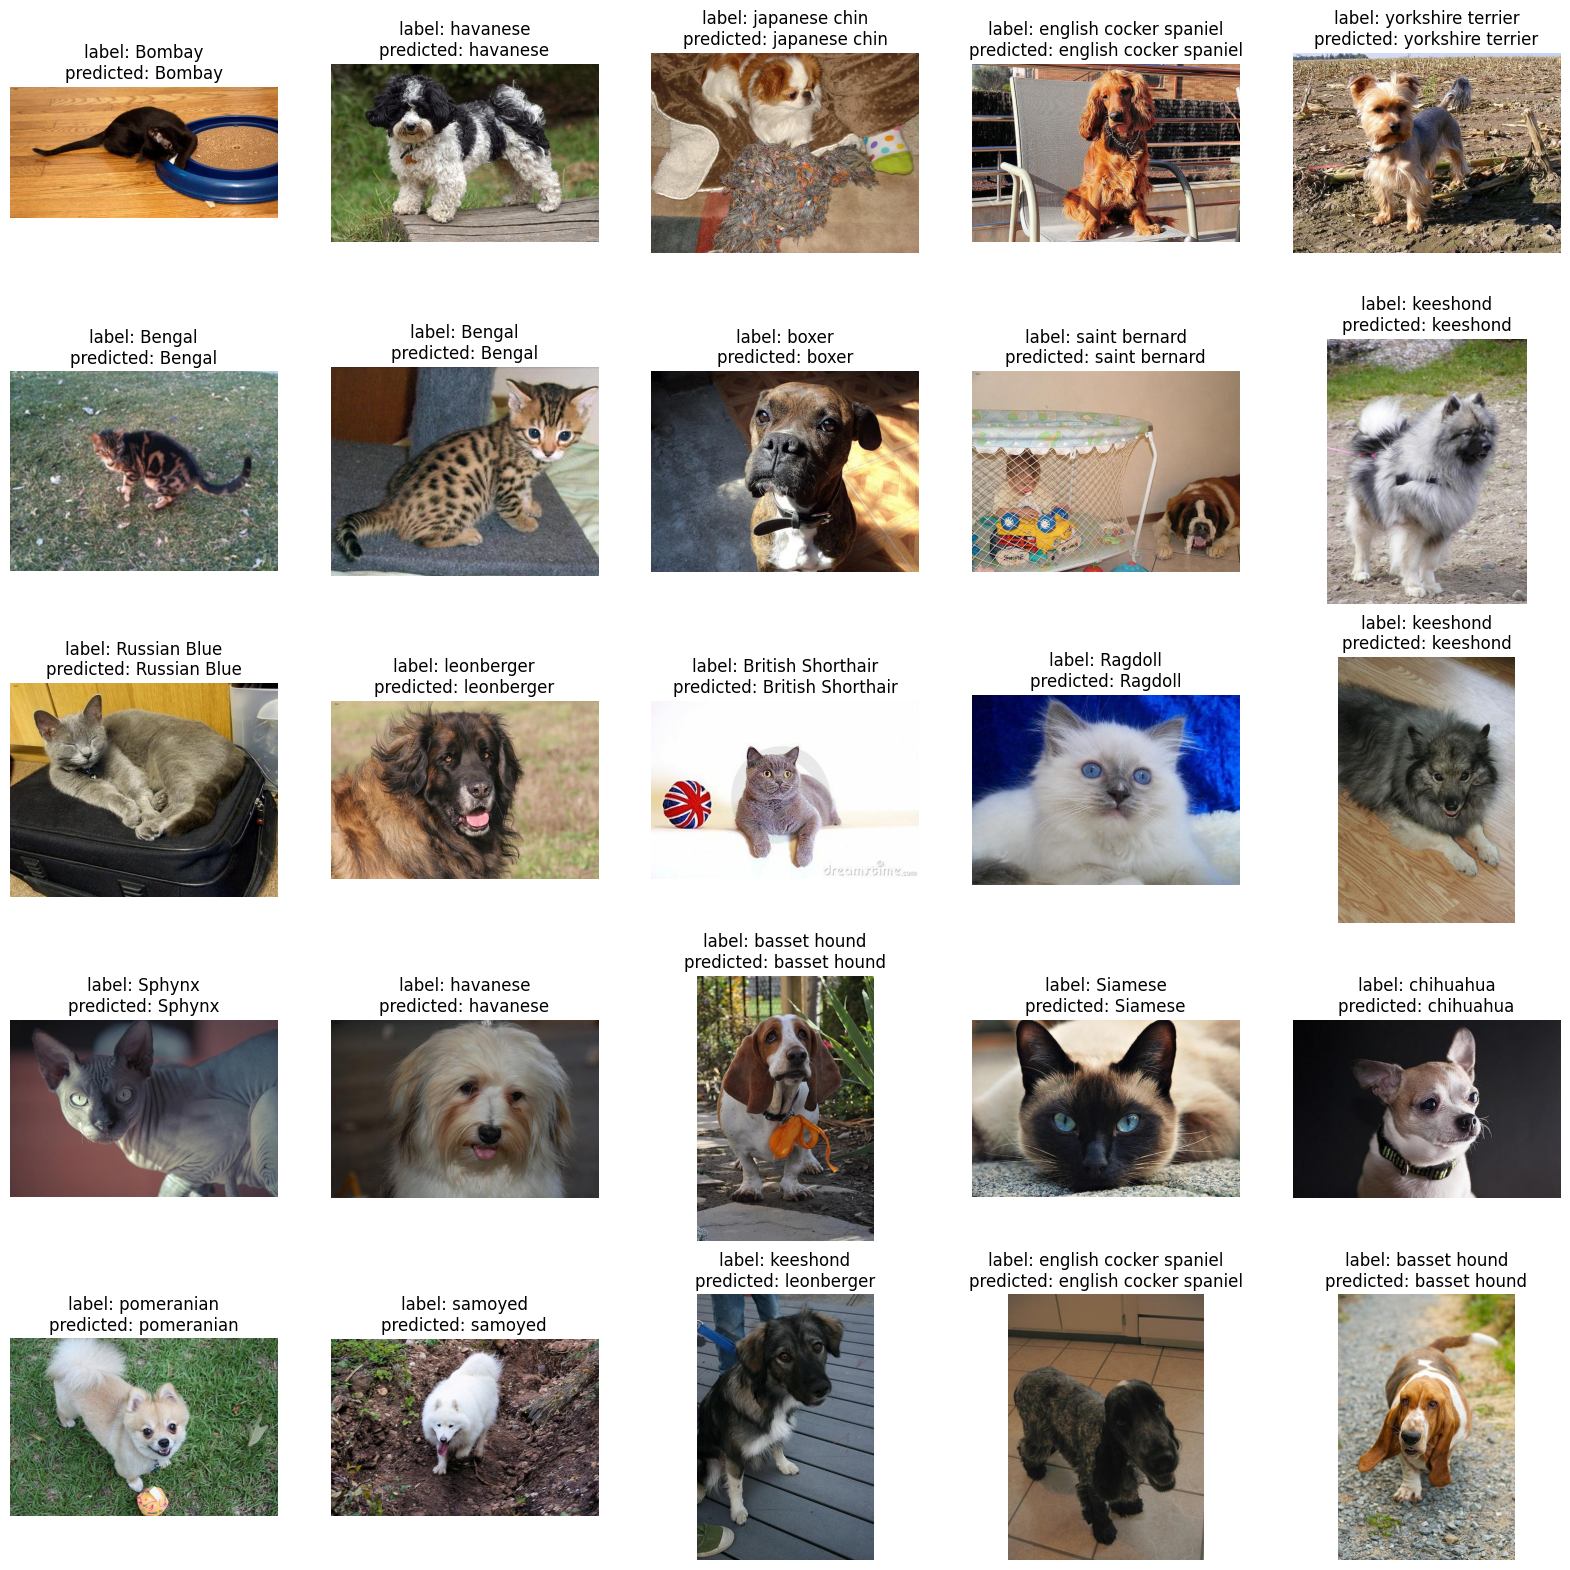

In [ ]:
def show_predictions(rows,cols):
    samples = our_dataset['test'].shuffle().select(np.arange(rows*cols))
    processed_samples = samples.with_transform(transforms)
    predictions = trainer.predict(processed_samples).predictions.argmax(axis=1) # predicted labels from logits
    fig = plt.figure(figsize=(cols*4,rows*4))
    for i in range(rows*cols):
        img_bytes = samples[i]['image']['bytes']
        img = Image.open(io.BytesIO(img_bytes))
        prediction = predictions[i]
        label = f"label: {samples[i]['label']}\npredicted: {id2label[prediction]}"
        fig.add_subplot(rows,cols,i+1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')

show_predictions(rows=5,cols=5)

### Our model works really well! Let's save it and also push it to Hugging Face model hub!

In [ ]:
kwargs = {
    "finetuned_from": model.config._name_or_path,
    "dataset": 'pcuenq/oxford-pets',
    "tasks": "image-classification",
    "tags": ['image-classification'],
}

In [ ]:
trainer.save_model()
trainer.push_to_hub('🐕️🐈️', **kwargs)

events.out.tfevents.1723901181.kitebrains2.10355.1:   0%|          | 0.00/411 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/kawchar85/vit-base-oxford-iiit-pets-v2/commit/d099b834f4ad0cef272789e16b1c92a883cefed7', commit_message='🐕️🐈️', commit_description='', oid='d099b834f4ad0cef272789e16b1c92a883cefed7', pr_url=None, pr_revision=None, pr_num=None)